In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.stats import describe
from tqdm import tqdm

from astropy.io import fits

from Py3D.core import image
from Py3D.functions import imageMethod

import seaborn as sns

sns.set(context="talk", style="ticks", palette="husl", color_codes=True)

In [2]:
# define lab data path following SDSS nomenclature
# examples of dark frames (non-zero length exposure, closed shutter)
# examples of bias frames (zero length exposure, closed shutter)
# identify regions: pre-scan, over-scan, science
# remove non-science regions: pre-scan, overscan
# compute bias statistics:
#  - mean, median, standard deviation
#  - if there are several exposures, look for statistical variations between exposures
#  - compare over-scan bias and science bias
# compute dark statistics:
#  - mean, median, standard deviation
#  - if there are several exposures, look for statistical variations between exposures
# hints of CCDflat: look for common patterns in both set of images
# look for structures in the OS regions

In [3]:
# data root path
LVM_DEV = os.path.expandvars("$LVMHUB")
LVM_ROOT = os.path.join(LVM_DEV, "data.sdss5.org/sas/sdsswork/data/lvm")
LVM_DATA_LAB = os.path.join(LVM_ROOT, "lab")

In [4]:

frames_meta = pd.read_csv(os.path.join(LVM_DATA_LAB, "LVMI Exposure List - Sheet1.csv"))
frames_meta.filename = frames_meta.filename.str.strip()
frames_meta.set_index(["mjd","filename"], inplace=True)
frames_meta = frames_meta.loc[~frames_meta.index.duplicated(keep="first")]
frames_meta = frames_meta.mask(frames_meta==-999)
frames_meta = frames_meta.drop(columns=frames_meta.filter(like="Unnamed"))
frames_meta = frames_meta.dropna(how="all", axis="columns").dropna(how="all", axis="index")

print(f"No. lab frames: {len(frames_meta)}")

No. lab frames: 1625


In [5]:
frame_paths = sorted([os.path.join(root,file) for root, _, files in os.walk(LVM_DATA_LAB) for file in files if (pd.to_numeric(os.path.basename(root),errors="ignore"),file) in frames_meta.index])
# frame_paths = sorted([os.path.join(root,file) for root, _, files in os.walk(LVM_DATA_LAB) for file in files if file.endswith(".fits") or file.endswith(".fits.gz")])
print(f"frames matched in lab data path: {len(frame_paths)}")

frames matched in lab data path: 1166


In [6]:
new_index = pd.MultiIndex.from_tuples(((pd.to_numeric(os.path.basename(os.path.dirname(file)),errors="ignore"),os.path.basename(file)) for file in frame_paths), names=("mjd", "filename"))
frames_header = pd.DataFrame(
    index=new_index,
    columns="IMAGETYP CCDTEMP1 CCDTEMP2 PRESURE LABTEMP LABHUMID".split()
)
for idx, frame_path in tqdm(enumerate(frame_paths), total=len(frame_paths), desc="reading metadata from headers", ascii=True):
    try:
        hdr = fits.getheader(frame_path)
    except OSError:
        continue
    for column in frames_header.columns:
        frames_header.iloc[idx].loc[column] = hdr.get(column, np.nan)
frames_header = frames_header.mask(frames_header==-999)

frames_meta_match = frames_meta.loc[new_index]
frames_meta_match = pd.concat((frames_meta_match, frames_header), axis="columns")
frames_meta_match["filepath"] = frame_paths

reading metadata from headers: 100%|##########| 1166/1166 [03:59<00:00,  4.88it/s]


<AxesSubplot:>

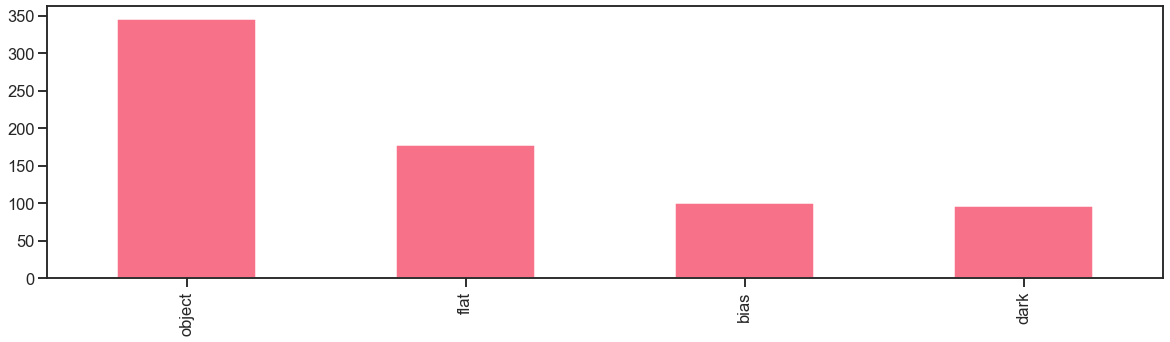

In [31]:
clean_frames = frames_meta_match.loc[(frames_meta_match.ccd_temp<0)&(~frames_meta_match.notes.fillna("").str.contains("bad", case=False))]
clean_frames.IMAGETYP.value_counts().plot(kind="bar", figsize=(20,5))

In [32]:
dark_frames = clean_frames.loc[clean_frames.IMAGETYP=="dark"]
bias_frames = clean_frames.loc[clean_frames.IMAGETYP=="bias"]
flat_frames = clean_frames.loc[clean_frames.IMAGETYP=="flat"]
lamp_frames = clean_frames.loc[clean_frames.IMAGETYP=="object"]

In [33]:
bias_frames

exp_no        date location test_no  \
mjd   filename                                                         
59435 sdR-s-r1-00000388.fits.gz     388  09/08/2021      SBS     NaN   
59445 sdR-s-r1-00000471.fits.gz     471  19/08/2021      SBS     NaN   
      sdR-s-r1-00000474.fits.gz     474  19/08/2021      SBS     NaN   
      sdR-s-r1-00000475.fits.gz     475  19/08/2021      SBS     NaN   
      sdR-s-r1-00000476.fits.gz     476  19/08/2021      SBS     NaN   
...                                 ...         ...      ...     ...   
59521 sdR-s-r1-00001027.fits.gz    1027  03/11/2021      SBS     NaN   
      sdR-s-z1-00001021.fits.gz    1021  03/11/2021      SBS     NaN   
      sdR-s-z1-00001025.fits.gz    1025  03/11/2021      SBS     NaN   
      sdR-s-z1-00001026.fits.gz    1026  03/11/2021      SBS     NaN   
      sdR-s-z1-00001027.fits.gz    1027  03/11/2021      SBS     NaN   

                                test_iteration spec channel sources  \
mjd   filename                                                        
59435 sdR-s-r1-00000388.fits.gz            NaN  sp1      r1     NaN   
59445 sdR-s-r1-00000471.fits.gz            NaN  sp1      r1     NaN   
      sdR-s-r1-00000474.fits.gz            NaN  sp1      r1     FFS   
      sdR-s-r1-00000475.fits.gz            NaN  sp1      r1     FFS   
      sdR-s-r1-00000476.fits.gz            NaN  sp1      r1     FFS   
...                                        ...  ...     ...     ...   
59521 sdR-s-r1-00001027.fits.gz            NaN  sp1      r1     FFS   
      sdR-s-z1-00001021.fits.gz            NaN  sp1      z1     FFS   
      sdR-s-z1-00001025.fits.gz            NaN  sp1      z1     FFS   
      sdR-s-z1-00001026.fits.gz            NaN  sp1      z1     FFS   
      sdR-s-z1-00001027.fits.gz            NaN  sp1      z1     FFS   

                                lamp_current hartmanns  ...  \
mjd   filename                                          ...   
59435 sdR-s-r1-00000388.fits.gz          NaN       L R  ...   
59445 sdR-s-r1-00000471.fits.gz          NaN       NaN  ...   
      sdR-s-r1-00000474.fits.gz          NaN       NaN  ...   
      sdR-s-r1-00000475.fits.gz          NaN       NaN  ...   
      sdR-s-r1-00000476.fits.gz          NaN       NaN  ...   
...                                      ...       ...  ...   
59521 sdR-s-r1-00001027.fits.gz          NaN         R  ...   
      sdR-s-z1-00001021.fits.gz          NaN         R  ...   
      sdR-s-z1-00001025.fits.gz          NaN         R  ...   
      sdR-s-z1-00001026.fits.gz          NaN         R  ...   
      sdR-s-z1-00001027.fits.gz          NaN         R  ...   

                                                           depth  \
mjd   filename                                                     
59435 sdR-s-r1-00000388.fits.gz                              NaN   
59445 sdR-s-r1-00000471.fits.gz                              NaN   
      sdR-s-r1-00000474.fits.gz                              NaN   
      sdR-s-r1-00000475.fits.gz                              NaN   
      sdR-s-r1-00000476.fits.gz                              NaN   
...                                                          ...   
59521 sdR-s-r1-00001027.fits.gz  A=-62.152, B=-62.482, C=-61.673   
      sdR-s-z1-00001021.fits.gz                              NaN   
      sdR-s-z1-00001025.fits.gz  A=-62.152, B=-62.481, C=-61.673   
      sdR-s-z1-00001026.fits.gz  A=-62.152, B=-62.481, C=-61.673   
      sdR-s-z1-00001027.fits.gz  A=-62.152, B=-62.481, C=-61.673   

                                       purpose  \
mjd   filename                                   
59435 sdR-s-r1-00000388.fits.gz            NaN   
59445 sdR-s-r1-00000471.fits.gz  Software test   
      sdR-s-r1-00000474.fits.gz            NaN   
      sdR-s-r1-00000475.fits.gz            NaN   
      sdR-s-r1-00000476.fits.gz            NaN   
...                                        ...   
59521 sdR-s-r1-00001027.fits.gz            NaN   
      sdR-s-z1-00

In [62]:
iframe = 12

frame = fits.open(bias_frames.filepath.values[iframe])

ny, nx = frame[0].data.shape
data = frame[0].data

frame[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4120                                                  
NAXIS2  =                 4080                                                  
SPEC    = 'sp1     '                                                            
OBSERVAT= 'LCO     '                                                            
OBSTIME = '2021-08-19T18:58:59.805' / Start of the observation                  
EXPTIME =                  0.0                                                  
IMAGETYP= 'bias    '                                                            
INTSTART= '2021-08-19T18:58:59.805' / Start of the integration                  
INTEND  = '2021-08-19T19:04:06.126' / End of the integration                    
CCD     = 'z1      '        

<BarContainer object of 4080 artists>

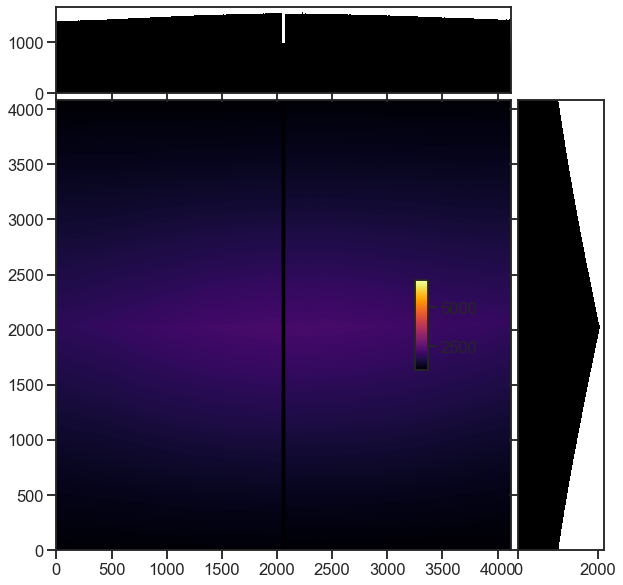

In [63]:
fig, ax = plt.subplots(figsize=(10,10))

im = ax.imshow(data, origin="lower", cmap="inferno")
ax.set_aspect(1.)

divider = make_axes_locatable(ax)

ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)
ax_color = inset_axes(
    ax,
    width="3%",
    height="20%",
    loc='center right',
    borderpad=5
)

ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)
# ax_histx.set_yscale("log")
# ax_histy.set_xscale("log")

cb = plt.colorbar(im, cax=ax_color)

ax_histx.bar(np.arange(nx), height=data.mean(axis=0), width=1, lw=0, align="center", color="k")
ax_histy.barh(np.arange(ny), width=data.mean(axis=1), height=1, lw=0, align="center", color="k")

final shape for amplifier region a: (2040, 2040)
final shape for amplifier region b: (2040, 2040)
final shape for amplifier region c: (2040, 2040)
final shape for amplifier region d: (2040, 2040)
{'a': 968.0, 'b': 990.0, 'c': 990.0, 'd': 965.0}
{'a': 1459.0, 'b': 1489.0, 'c': 1491.0, 'd': 1486.0}


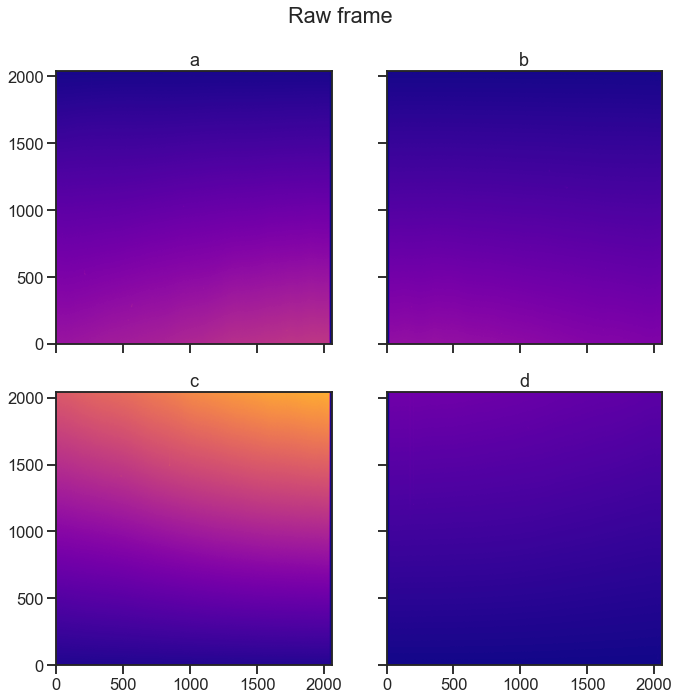

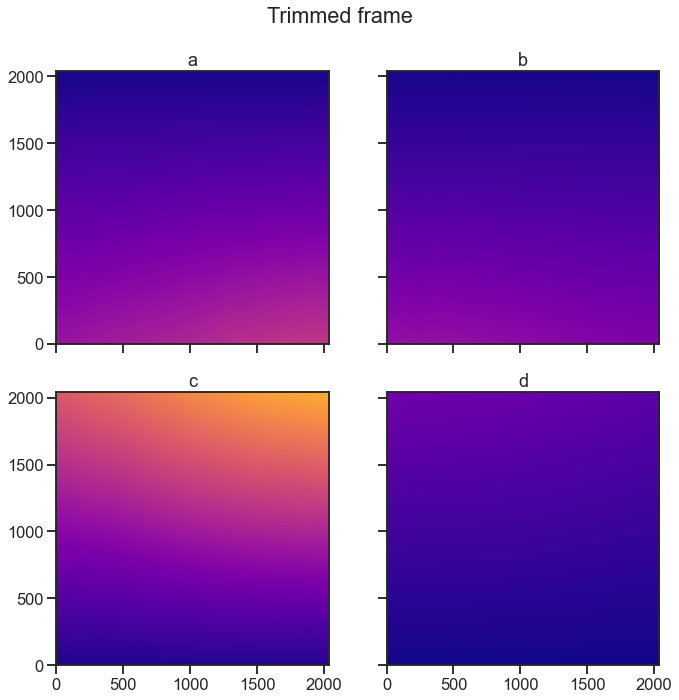

In [66]:
AMPLIFIER_WIDTH, AMPLIFIER_HEIGHT = nx//2, ny//2
OVERSCAN_WIDTH = 20
PRESCAN_WIDTH = 4
AMPLIFIER_NAMES = list("abcd")

fig_raw, axs_raw = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
axs_raw = axs_raw.ravel()

fig_cut, axs_cut = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
axs_cut = axs_cut.ravel()

amplifiers = dict.fromkeys(AMPLIFIER_NAMES)
amplifiers["a"] = image.Image(data=data[AMPLIFIER_HEIGHT:,:AMPLIFIER_WIDTH])
amplifiers["b"] = image.Image(data=data[AMPLIFIER_HEIGHT:,AMPLIFIER_WIDTH:])
amplifiers["c"] = image.Image(data=data[:AMPLIFIER_HEIGHT,:AMPLIFIER_WIDTH])
amplifiers["d"] = image.Image(data=data[:AMPLIFIER_HEIGHT,AMPLIFIER_WIDTH:])

os_bias = dict.fromkeys(AMPLIFIER_NAMES)
fr_bias = dict.fromkeys(AMPLIFIER_NAMES)
for i, amp in enumerate(AMPLIFIER_NAMES):
    axs_raw[i].imshow(amplifiers[amp]._data, origin="lower", cmap="plasma")
    axs_raw[i].set_title(amp)
    if amp in "ac":
        os_bias[amp] = amplifiers[amp].cutOverscan(bound_x=(1,AMPLIFIER_HEIGHT), bound_y=(1,AMPLIFIER_WIDTH-OVERSCAN_WIDTH), subtract=False)
    if amp in "bd":
        os_bias[amp] = amplifiers[amp].cutOverscan(bound_x=(1+OVERSCAN_WIDTH,AMPLIFIER_WIDTH), bound_y=(1,AMPLIFIER_HEIGHT), subtract=False)
    fr_bias[amp] = np.median(amplifiers[amp]._data)

    axs_cut[i].imshow(amplifiers[amp]._data, origin="lower", cmap="plasma")
    axs_cut[i].set_title(amp)
    
    print(f"final shape for amplifier region {amp}: {amplifiers[amp]._dim}")

fig_raw.suptitle("Raw frame")
fig_raw.tight_layout()
fig_cut.suptitle("Trimmed frame")
fig_cut.tight_layout()

print(os_bias)
print(fr_bias)

In [67]:
AXES_NAMES = "xy"
STATS_FIELDS = (
    "os_bias fr_bias".split() +
    [f"{stat}_{ax}" for ax in AXES_NAMES for stat in "min max median mean std skew kurt".split()]
)
STATS_FIELDS = [f"{field}_{amp}" for amp in AMPLIFIER_NAMES for field in STATS_FIELDS]

frames_stats = dict.fromkeys(bias_frames.index)
for iframe, idx in tqdm(enumerate(bias_frames.index), total=len(bias_frames), desc="computing frames stats", unit="frame", ascii=True):
    header = fits.getheader(bias_frames.filepath.values[iframe])
    data = fits.getdata(bias_frames.filepath.values[iframe])

    row = dict.fromkeys(STATS_FIELDS, np.nan)
    if data.size == 0:
        frames_stats[idx] = row
        continue

    amplifiers = dict.fromkeys(AMPLIFIER_NAMES)
    amplifiers["a"] = image.Image(data=data[AMPLIFIER_HEIGHT:,:AMPLIFIER_WIDTH])
    amplifiers["b"] = image.Image(data=data[AMPLIFIER_HEIGHT:,AMPLIFIER_WIDTH:])
    amplifiers["c"] = image.Image(data=data[:AMPLIFIER_HEIGHT,:AMPLIFIER_WIDTH])
    amplifiers["d"] = image.Image(data=data[:AMPLIFIER_HEIGHT,AMPLIFIER_WIDTH:])

    for i, amp in enumerate(AMPLIFIER_NAMES):
        if amp in "ac":
            row[f"os_bias_{amp}"] = amplifiers[amp].cutOverscan(bound_x=(1,AMPLIFIER_HEIGHT), bound_y=(1,AMPLIFIER_WIDTH-OVERSCAN_WIDTH), subtract=False)
        if amp in "bd":
            row[f"os_bias_{amp}"] = amplifiers[amp].cutOverscan(bound_x=(1+OVERSCAN_WIDTH,AMPLIFIER_WIDTH), bound_y=(1,AMPLIFIER_HEIGHT), subtract=False)
        
        row[f"fr_bias_{amp}"] = np.median(amplifiers[amp]._data)
        for iax, ax in enumerate(AXES_NAMES):
            _, (_min, _max), mean, var, skew, kurt = describe(amplifiers[amp]._data.mean(axis=iax))
            median = np.median(amplifiers[amp]._data.mean(axis=iax))
            
            row[f"median_{ax}_{amp}"] = median
            row[f"min_{ax}_{amp}"] = _min
            row[f"max_{ax}_{amp}"] = _max
            row[f"mean_{ax}_{amp}"] = mean
            row[f"std_{ax}_{amp}"] = np.sqrt(var)
            row[f"skew_{ax}_{amp}"] = skew
            row[f"kurt_{ax}_{amp}"] = kurt
    
    frames_stats[idx] = row

computing frames stats: 100%|##########| 100/100 [01:39<00:00,  1.01frame/s]


In [68]:
# filter by:
#  - exptime (0, 1)
#  - channel (r1, b1, z1)
#  - spec (eventually)

stats = pd.DataFrame.from_dict(frames_stats, orient="index")
stats.describe().T

,count,mean,std,min,25%,50%,75%,max
os_bias_a,100.0,1076.730000,233.802941,941.000000,970.000000,999.000000,1021.000000,2009.000000
fr_bias_a,100.0,21230.350000,24897.877273,945.000000,999.000000,1489.000000,36021.750000,65535.000000
min_x_a,100.0,1079.285902,257.445434,910.610784,953.842402,995.100245,1031.721324,2365.240196
max_x_a,100.0,22378.659363,25047.662314,949.628922,998.818750,2516.330882,38920.188113,65535.000000
median_x_a,100.0,21034.411485,24199.408787,944.497549,998.754779,1518.995098,36932.348039,65534.596814
...,...,...,...,...,...,...,...,...
median_y_d,100.0,21672.073902,25043.223585,936.812255,999.587255,1486.894608,37625.248100,65443.646078
mean_y_d,100.0,21310.896772,24480.413406,936.811990,999.584774,1500.022618,37063.324676,65171.538860
std_y_d,100.0,5660.972361,7788.830220,0.016541,2.848701,163.955065,15197.284597,21135.630274
skew_y_d,100.0,0.322403,6.385506,-9.653594,-0.634083,0.009078,0.149145,39.329531


In [70]:
# bias_mask = bias.exptime==0
# dark_mask = table.exptime>0

bias_full = stats.loc[bias_frames.index]
bias_full.loc[:,"channel"] = bias_frames.loc[:,"channel"]

# dark_full = stats.loc[dark_mask]
# dark_full.loc[:,"channel"] = table.loc[:,"channel"]

bias_desc = bias_full.describe()
# dark_desc = dark_full.describe()

         median_x_a    median_y_a    median_x_b    median_y_b    median_x_c    median_y_c    median_x_d    median_y_d
count    100.000000    100.000000    100.000000    100.000000    100.000000    100.000000    100.000000    100.000000
mean   21034.411485  21262.739431  19775.292909  19850.938392  22884.891505  23479.483020  21464.053201  21672.073902
std    24199.408787  24836.616159  23325.440555  23899.583838  25658.163412  26378.230253  24744.632615  25043.223585
min      944.497549    945.072794    965.525490    968.580392     50.983824     40.628186    936.707843    936.812255
25%      998.754779    998.556250    998.507904    998.068199    999.488971    999.509681    999.525429    999.587255
50%     1518.995098   1493.476225   1506.031127   1508.506127   1510.535294   1485.647672   1510.952574   1486.894608
75%    36932.348039  36122.939154  32042.580270  30483.695466  43440.349203  47331.761703  37571.464583  37625.248100
max    65534.596814  65442.863235  64960.215931  65442.7

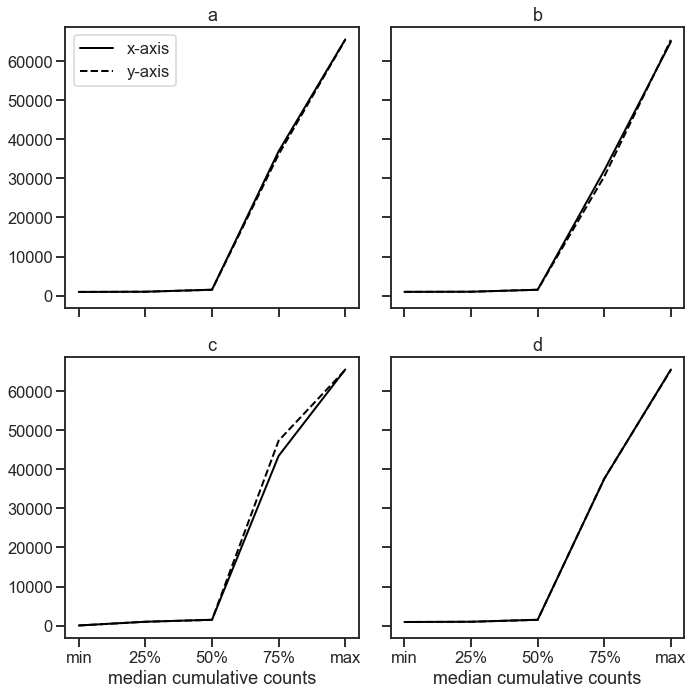

In [71]:
st_name = "median"
percentiles = "min 25% 50% 75% max".split()

fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
axs = axs.ravel()

stat_df = bias_desc.filter(like=f"{st_name}")
print(stat_df.to_string())
for i, amp in enumerate(AMPLIFIER_NAMES):
    axs[i].plot(percentiles, stat_df.loc[percentiles,f"{st_name}_x_{amp}"], "-", color="k", lw=2, label="x-axis")
    axs[i].plot(percentiles, stat_df.loc[percentiles,f"{st_name}_y_{amp}"], "--", color="k", lw=2, label="y-axis")
    axs[i].set_title(amp)

axs[0].legend(loc=2)
axs[-2].set_xlabel(f"{st_name} cumulative counts")
axs[-1].set_xlabel(f"{st_name} cumulative counts")
fig.tight_layout()

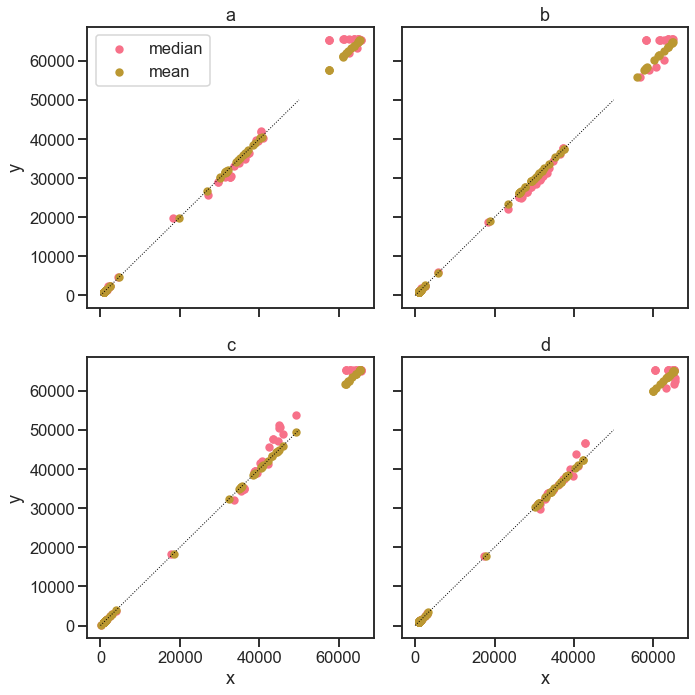

In [73]:
st_names = ["median", "mean"]
percentiles = "min 25% 50% 75% max".split()

fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
axs = axs.ravel()

stat_df = bias_full.copy()
xx = [0,50000]
for i, amp in enumerate(AMPLIFIER_NAMES):
    axs[i].set_title(amp)
    for st_name in st_names:
        axs[i].scatter(stat_df.loc[:,f"{st_name}_x_{amp}"], stat_df.loc[:,f"{st_name}_y_{amp}"], s=70, lw=0, label=st_name)
    axs[i].plot(xx, xx, lw=1, ls=":", color="k")

axs[0].legend(loc=2)
axs[-1].set_xlabel(f"x")
axs[-2].set_xlabel(f"x")
axs[0].set_ylabel(f"y")
axs[-2].set_ylabel(f"y")
fig.tight_layout()

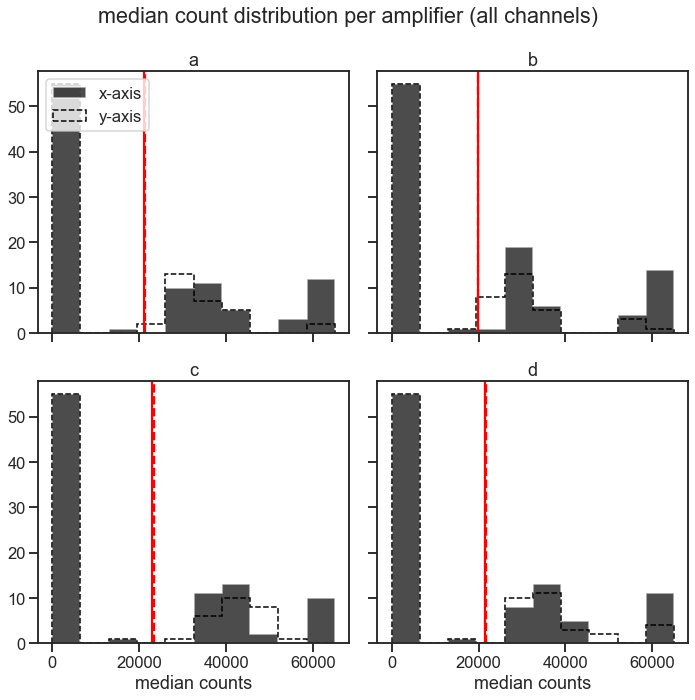

In [74]:
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
axs = axs.ravel()

st_name = "median"
stat_df = bias_full.copy()
for i, amp in enumerate(AMPLIFIER_NAMES):
    axs[i].hist(stat_df.loc[:,f"{st_name}_x_{amp}"], range=(0,65000), bins=10, color="k", alpha=0.7, histtype="stepfilled", label="x-axis")
    axs[i].hist(stat_df.loc[:,f"{st_name}_y_{amp}"], range=(0,65000), bins=10, color="k", alpha=1.0, histtype="step", ls="--", label="y-axis")
    axs[i].axvline(stat_df.loc[:,f"{st_name}_x_{amp}"].mean(), ls="-", color="r")
    axs[i].axvline(stat_df.loc[:,f"{st_name}_y_{amp}"].mean(), ls="--", color="r")
    axs[i].set_title(amp)

axs[0].legend(loc=2)
axs[-2].set_xlabel(f"{st_name} counts")
axs[-1].set_xlabel(f"{st_name} counts")
fig.suptitle(f"{st_name} count distribution per amplifier (all channels)")
fig.tight_layout()

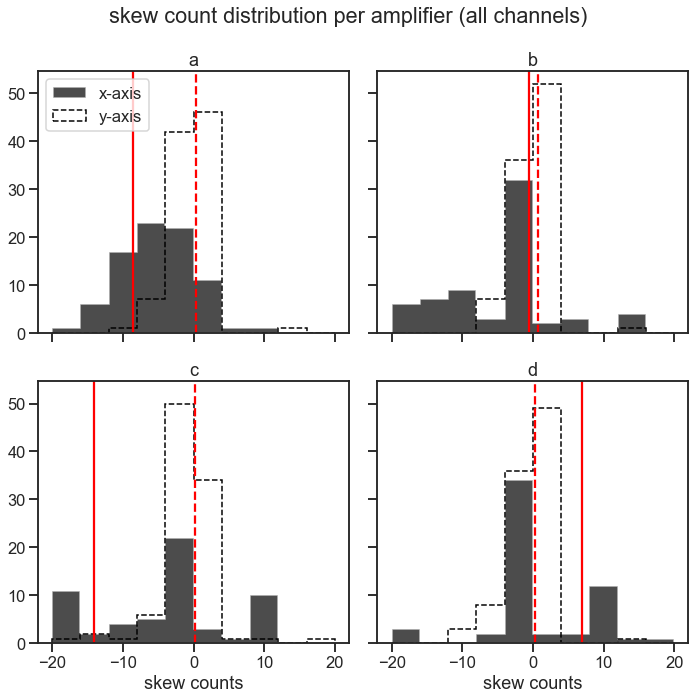

In [75]:
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
axs = axs.ravel()

st_name = "skew"
stat_df = bias_full.copy()
for i, amp in enumerate(AMPLIFIER_NAMES):
    axs[i].hist(stat_df.loc[:,f"{st_name}_x_{amp}"], range=(-20,20), bins=10, color="k", alpha=0.7, histtype="stepfilled", label="x-axis")
    axs[i].hist(stat_df.loc[:,f"{st_name}_y_{amp}"], range=(-20,20), bins=10, color="k", alpha=1.0, histtype="step", ls="--", label="y-axis")
    axs[i].axvline(stat_df.loc[:,f"{st_name}_x_{amp}"].mean(), ls="-", color="r")
    axs[i].axvline(stat_df.loc[:,f"{st_name}_y_{amp}"].mean(), ls="--", color="r")
    axs[i].set_title(amp)

axs[0].legend(loc=2)
axs[-2].set_xlabel(f"{st_name} counts")
axs[-1].set_xlabel(f"{st_name} counts")
fig.suptitle(f"{st_name} count distribution per amplifier (all channels)")
fig.tight_layout()

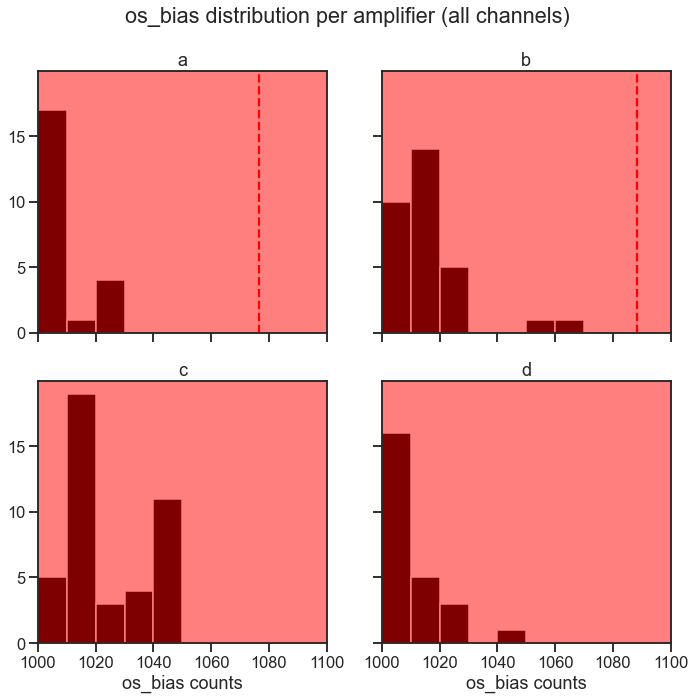

In [76]:
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
axs = axs.ravel()

st_name = "os_bias"
stat_df = bias_full.filter(like=st_name)
for i, amp in enumerate(AMPLIFIER_NAMES):
    axs[i].hist(stat_df.loc[:,f"{st_name}_{amp}"], range=(1000,1100), bins=10, color="k")
    mean, std = stat_df.loc[:,f"{st_name}_{amp}"].mean(), stat_df.loc[:,f"{st_name}_{amp}"].std()
    axs[i].axvspan(mean-std, mean+std, lw=0, fc="r", alpha=0.5)
    axs[i].axvline(mean, ls="--", color="r")
    axs[i].set_title(amp)

axs[-2].set_xlabel(f"{st_name} counts")
axs[-1].set_xlabel(f"{st_name} counts")
fig.suptitle(f"{st_name} distribution per amplifier (all channels)")
plt.xlim(1000,1100)
fig.tight_layout()

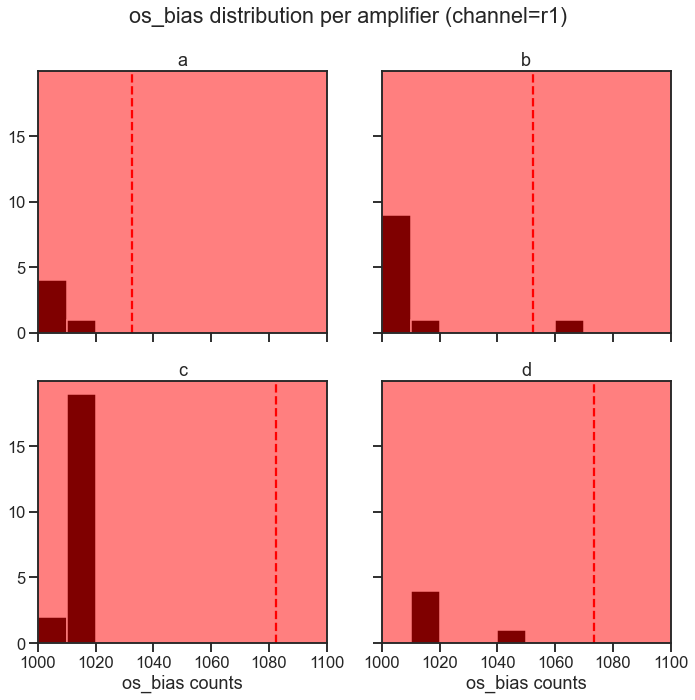

In [77]:
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
axs = axs.ravel()

channel = "r1"
st_name = "os_bias"
stat_df = bias_full.loc[bias_full.channel==channel].filter(like=st_name)
for i, amp in enumerate(AMPLIFIER_NAMES):
    axs[i].hist(stat_df.loc[:,f"{st_name}_{amp}"], range=(1000,1100), bins=10, color="k")
    mean, std = stat_df.loc[:,f"{st_name}_{amp}"].mean(), stat_df.loc[:,f"{st_name}_{amp}"].std()
    axs[i].axvspan(mean-std, mean+std, lw=0, fc="r", alpha=0.5)
    axs[i].axvline(mean, ls="--", color="r")
    axs[i].set_title(amp)

axs[-2].set_xlabel(f"{st_name} counts")
axs[-1].set_xlabel(f"{st_name} counts")
fig.suptitle(f"{st_name} distribution per amplifier (channel={channel})")
plt.xlim(1000,1100)
fig.tight_layout()

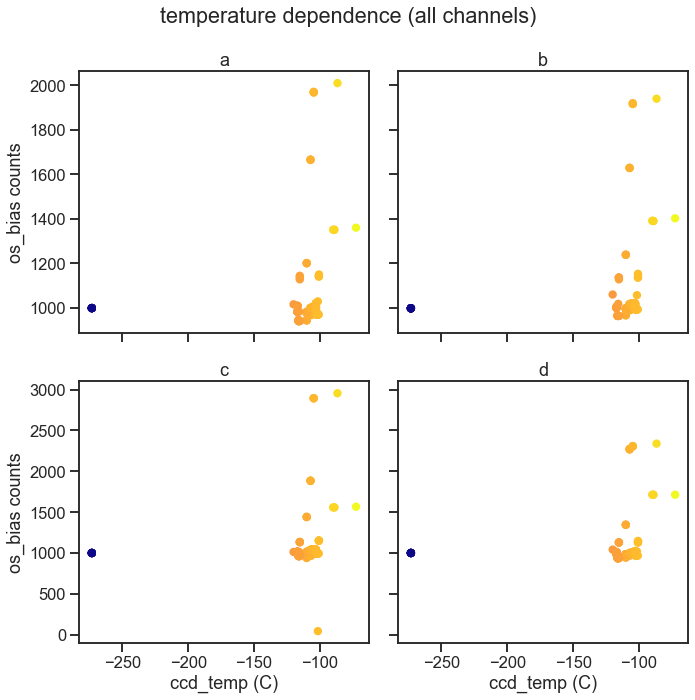

In [78]:
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey="row")
axs = axs.ravel()

st_name = "os_bias"
x_name = "ccd_temp"
z_name = "lab_temp"
stat_df = pd.concat((bias_full,bias_frames.filter(["lab_temp", "ccd_temp"])), axis="columns")
for i, amp in enumerate(AMPLIFIER_NAMES):
    axs[i].scatter(stat_df.loc[:,x_name], stat_df.loc[:,f"{st_name}_{amp}"], c=stat_df.loc[:,x_name], s=70, lw=0, cmap="plasma")
    axs[i].set_title(amp)

axs[-2].set_xlabel(f"{x_name} (C)")
axs[-1].set_xlabel(f"{x_name} (C)")
axs[0].set_ylabel(f"{st_name} counts")
axs[-2].set_ylabel(f"{st_name} counts")
fig.suptitle("temperature dependence (all channels)")
fig.tight_layout()